**Import packages**

Import all the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import seaborn as sns
import os
import json

from transformers import BertTokenizerFast, BertModel
import torch
import torch.nn as nn
import torch.functional as F
from torch.optim import Adam
from sklearn.metrics import classification_report, confusion_matrix

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()

**Load the IMDB dataset**

Run the following cell to download the IMDB dataset. Alternatively, you can download the dataset using this [link](https://raw.githubusercontent.com/SagarParekh97/NLP-Fall-2023/main/Assignment%201/IMDB%20Dataset.csv)

In [2]:
link_to_dataset = 'https://raw.githubusercontent.com/SagarParekh97/NLP-Fall-2023/main/Assignment%201/IMDB%20Dataset.csv'

dataset = pd.read_csv(link_to_dataset)
print('----- Dataset -----')
print(dataset)
class_name = ['negative', 'positive']

----- Dataset -----
                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


**Divide the dataset into Training, Development, and Test sets**

Training - 39723 reviews (80%)

Development - 4998 reviews (10%)

Test - 4995 reviews (10%)

In [3]:
# shuffle the dataset
dataset = dataset.sample(frac=1)
# split dataset according to the required size
train, development, test, _ = np.split(dataset, [39723, 39723 + 4998, 39723 + 4998 + 4995])

print(f'Length of train: {len(train)}\nLength of development: {len(development)}\nLength of test: {len(test)}')

Length of train: 39723
Length of development: 4998
Length of test: 4995


/home/sagar-legion/miniconda3/envs/nlp_hw1_906466769/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


**Validate the datasets**

Check if the test, train, and development sets have a balanced distribution of classes

Text(0.5, 1.0, 'Test')

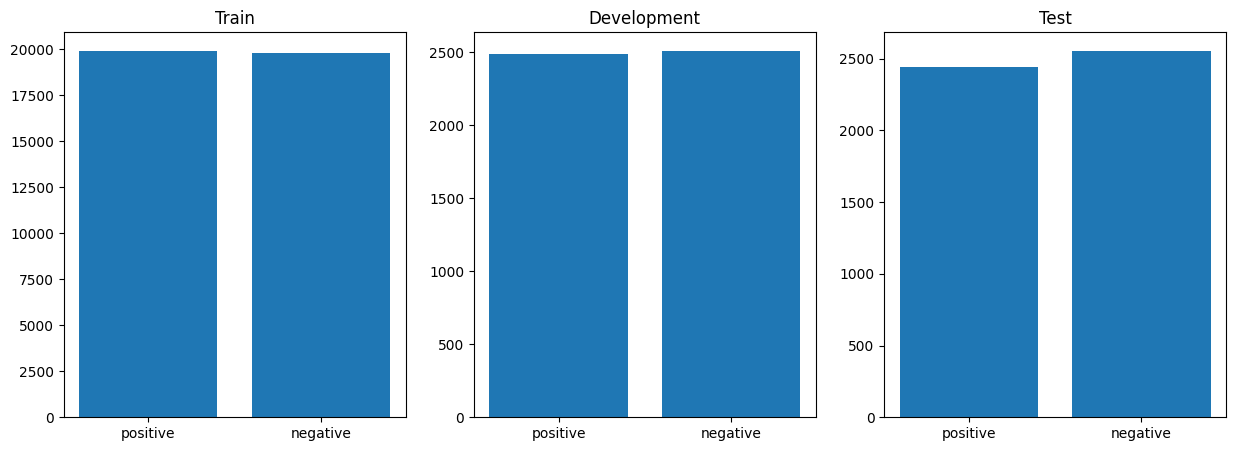

In [4]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].bar(['positive', 'negative'], [np.sum(train.sentiment == 'positive'), np.sum(train.sentiment == 'negative')])
ax[0].set_title('Train')
ax[1].bar(['positive', 'negative'], [np.sum(development.sentiment == 'positive'), np.sum(development.sentiment == 'negative')])
ax[1].set_title('Development')
ax[2].bar(['positive', 'negative'], [np.sum(test.sentiment == 'positive'), np.sum(test.sentiment == 'negative')])
ax[2].set_title('Test')

We have confirmed that all the sets have approaximately equal number of datapoints for each class label

**Choosing the max length for tokens**

Load the BERT pre-trained tokenizer.

In [5]:
MODEL_NAME = 'bert-base-cased'

The dataset contains many long reviews with over 1000 tokens. We choose the max_length for the tokens to be 512 and truncate the reviews longer than that.

In [6]:
MAX_LENGTH = 512
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

**Toeknize the text using pre-trained BERT**

We change the sentiment labels to binary index values
0: negative sentiment
1: positive sentiment

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, dataset, device):
        self.tokenizer = tokenizer
        self.reviews = dataset.review.tolist()
        self.targets = dataset.sentiment.apply({'negative': 0, 'positive': 1}.get).to_numpy()
        self.device = device

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        output = dict()
        tokens = tokenizer(self.reviews[index], max_length=MAX_LENGTH, truncation=True,
                           padding='max_length')

        output['review'] = self.reviews[index]
        output['id'] = torch.tensor(tokens['input_ids'], dtype=torch.long)
        output['mask'] = torch.tensor(tokens['attention_mask'], dtype=torch.long)
        output['token_type_id'] = torch.tensor(tokens['token_type_ids'], dtype=torch.long)
        output['target'] = torch.tensor(self.targets[index], dtype=torch.long)

        return output

train_dataset = Dataset(tokenizer, train, device)
test_dataset = Dataset(tokenizer, test, device)
development_dataset = Dataset(tokenizer, development, device)

**Sentiment Classifier**

This is the model architecture designed for sentiment classification.

In [8]:
class BERTClassifier(nn.Module):
    def __init__(self, dropout: float=0.3, output_size: int=2):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.d1 = nn.Dropout(dropout)
        self.l1 = nn.Linear(self.bert.config.hidden_size, output_size)

        self.loss_fcn = nn.CrossEntropyLoss()

    def forward(self, ids, masks, targets):
        outputs = self.bert(input_ids=ids, attention_mask=masks)

        outputs = self.d1(outputs[1])
        outputs = self.l1(outputs)

        _, predictions = torch.max(outputs, axis=1)

        return predictions, self.loss(outputs, targets)

    def loss(self, outputs, targets):
        return self.loss_fcn(outputs, targets)
        

Create functions to train and evaluate the fine-tuned BERT model

In [9]:
def trainer(model, dataset, optimizer, epochs, params_dataLoader, device):
    dataset_loader = torch.utils.data.DataLoader(dataset, **params_dataLoader)

    training_loss = []
    training_accuracy = []
    for e in tqdm(range(epochs)):
        correct_predictions = 0
        for data in tqdm(dataset_loader):
            ids = data['id'].to(device)
            masks = data['mask'].to(device)
            targets = data['target'].to(device)

            prediction, loss = model(ids, masks, targets)
            training_loss.append(loss.item())
            correct_predictions += torch.sum(prediction == targets).cpu().detach().numpy()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        training_accuracy.append((e, correct_predictions / len(dataset)))

    # save the trained models
    model_checkpoint = dict()
    model_checkpoint['model_state_dict'] = model.state_dict()
    model_checkpoint['optimizer_state_dict'] = optimizer.state_dict()
    model_checkpoint['training_loss'] = training_loss
    model_checkpoint['training_accuracy'] = training_accuracy
    torch.save(model_checkpoint, f'./save_data/model_checkpoint.pth')
    return training_loss, training_accuracy

In [10]:
def eval(model, dataset, params_dataLoader, device):
    dataset_loader = torch.utils.data.DataLoader(dataset, **params_dataLoader)

    y_pred = []
    y_true = []
    for data in tqdm(dataset_loader):
        ids = data['id'].to(device)
        masks = data['mask'].to(device)
        targets = data['target'].to(device)

        y_true.append(targets.cpu().detach().numpy())
        with torch.no_grad():
            prediction, _ = model(ids, masks, targets)
            
            y_pred.append(prediction.cpu().detach().numpy().item())
        
    report = classification_report(y_true, y_pred, target_names=class_name)
    conf_mat = confusion_matrix(y_true, y_pred)

    return report, conf_mat

The BERT authors have some recommendations for fine-tuning:

    Batch size: 16, 32
    Learning rate (Adam): 5e-5, 3e-5, 2e-5
    Number of epochs: 2, 3, 4

We use these suggestions to guide our hyperparameters values; we initialize the model and optimizer

In [11]:
LR = 2e-5
TRAINING_BATCH_SIZE = 16
TEST_BATCH_SIZE = 1
EPOCHS = 4
DROPOUT = 0.3
N_CLASSES = 2
NUM_WORKERS = 4

params_dataLoader = {'batch_size': TRAINING_BATCH_SIZE,
                     'shuffle': True,
                     'num_workers': NUM_WORKERS}

model = BERTClassifier(dropout=DROPOUT, output_size=N_CLASSES).to(device)
optimizer = Adam(model.parameters(), lr=LR)

**Train**

 If you want to load a previously trained model, press y

Text(0.5, 1.0, 'Training Accuracy')

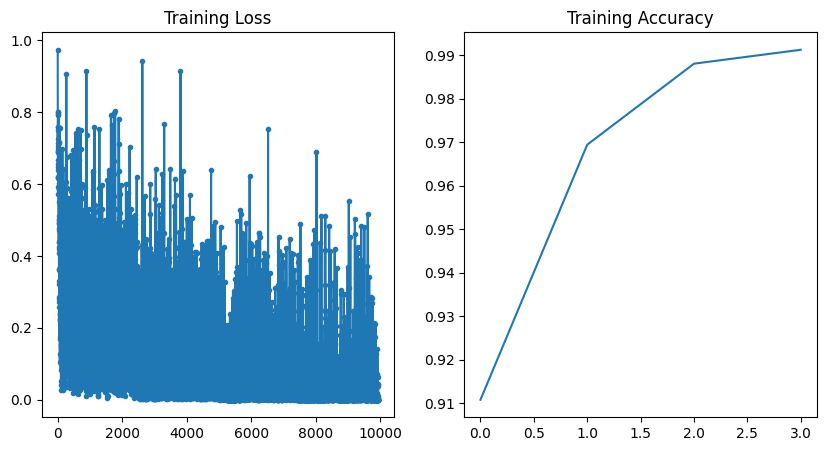

In [12]:
load = all([os.path.exists(f'save_data/{f}') for f in ['model_checkpoint.pth', 'training_loss.json', 'training_accuracy.json']])

if load:
    model_dir = 'save_data/model_checkpoint.pth'
    model_checkpoint = torch.load(model_dir)
    model.load_state_dict(model_checkpoint['model_state_dict'])

    fname = os.path.join(f'./save_data/training_loss.json')
    with open(fname, 'r') as f:
        training_loss = json.load(f)
    fname = os.path.join(f'./save_data/training_accuracy.json')
    with open(fname, 'r') as f:
        training_accuracy = json.load(f)
else:
    if not os.path.exists('save_data/'):
        os.makedirs('save_data')
    training_loss, training_accuracy = trainer(model, train_dataset, optimizer, EPOCHS, params_dataLoader, device)

    fname = os.path.join(f'./save_data/training_loss.json')
    with open(fname, 'w') as f:
        json.dump(training_loss, f)
    fname = os.path.join(f'./save_data/training_accuracy.json')
    with open(fname, 'w') as f:
        json.dump(training_accuracy, f)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(training_loss, marker='.')
ax[0].set_title('Training Loss')
ax[1].plot(*zip(*training_accuracy))
ax[1].set_title('Training Accuracy')

We can see that as the training loss converges the training accuracy reached close to 1

**Evaluate**

Now, we evaluate the performance of the fine-tuned BERT model on the train, test, and development sets.

Set the parameters for the eval dataloader

In [13]:
params_dataLoader_eval = {'batch_size': TEST_BATCH_SIZE,
                          'shuffle': True,
                          'num_workers': NUM_WORKERS}

Train set

In [14]:
# train_report, train_conf_mat = eval(model, train_dataset, params_dataLoader_eval, device)

# _, ax = plt.subplots(1, 1, figsize=(7, 7))
# ax.matshow(train_conf_mat, cmap=plt.cm.Blues, alpha=0.3)
# for i in range(train_conf_mat.shape[0]):
#     for j in range(train_conf_mat.shape[1]):
#         ax.text(x=j, y=i, s=train_conf_mat[i, j], va='center', ha='center', size='xx-large')
# ax.set_xlabel('Predictions')
# ax.set_ylabel('Actuals')
# ax.set_xticks(range(len(class_name)))
# ax.set_yticks(range(len(class_name)))
# ax.set_xticklabels(class_name)
# ax.set_yticklabels(class_name)
# ax.set_title('Train Confusion Matrix')

# print('F-Score')
# print(train_report)

Test set

  0%|          | 0/4995 [00:00<?, ?it/s]

F-Score
              precision    recall  f1-score   support

    negative       0.98      0.99      0.98      2555
    positive       0.98      0.98      0.98      2440

    accuracy                           0.98      4995
   macro avg       0.98      0.98      0.98      4995
weighted avg       0.98      0.98      0.98      4995



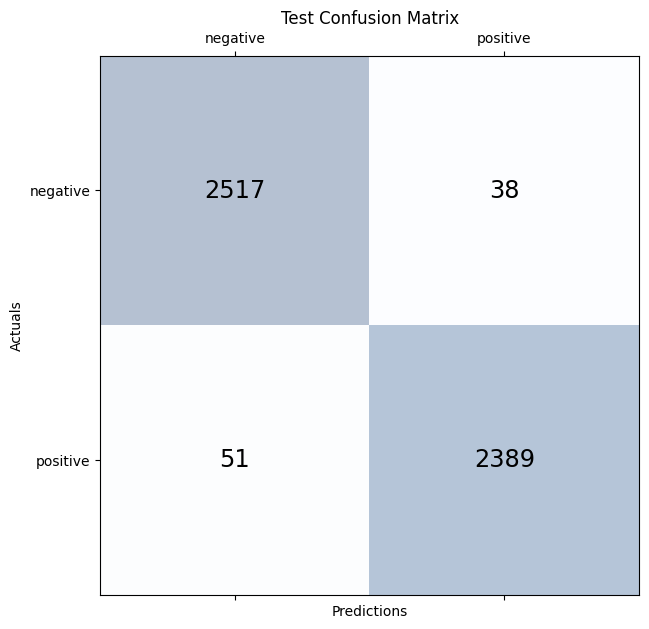

In [15]:
test_report, test_conf_mat = eval(model, test_dataset, params_dataLoader_eval, device)
_, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.matshow(test_conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(test_conf_mat.shape[0]):
    for j in range(test_conf_mat.shape[1]):
        ax.text(x=j, y=i, s=test_conf_mat[i, j], va='center', ha='center', size='xx-large')
ax.set_xlabel('Predictions')
ax.set_ylabel('Actuals')
ax.set_xticks(range(len(class_name)))
ax.set_yticks(range(len(class_name)))
ax.set_xticklabels(class_name)
ax.set_yticklabels(class_name)
ax.set_title('Test Confusion Matrix')

print('F-Score')
print(test_report)

Development set

  0%|          | 0/4998 [00:00<?, ?it/s]

F-Score
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      2511
    positive       0.99      0.99      0.99      2487

    accuracy                           0.99      4998
   macro avg       0.99      0.99      0.99      4998
weighted avg       0.99      0.99      0.99      4998



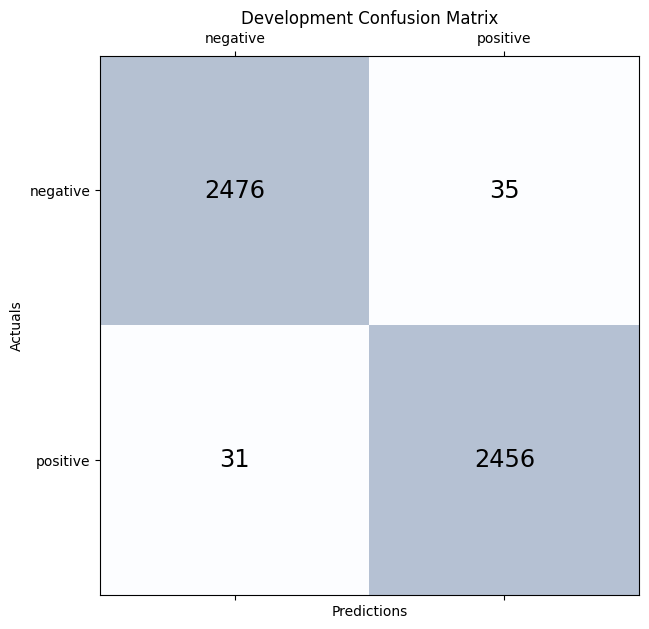

In [16]:
devel_report, devel_conf_mat = eval(model, development_dataset, params_dataLoader_eval, device)
_, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.matshow(devel_conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(devel_conf_mat.shape[0]):
    for j in range(devel_conf_mat.shape[1]):
        ax.text(x=j, y=i, s=devel_conf_mat[i, j], va='center', ha='center', size='xx-large')
ax.set_xlabel('Predictions')
ax.set_ylabel('Actuals')
ax.set_xticks(range(len(class_name)))
ax.set_yticks(range(len(class_name)))
ax.set_xticklabels(class_name)
ax.set_yticklabels(class_name)
ax.set_title('Development Confusion Matrix')

print('F-Score')
print(devel_report)

**Save a pdf output of the notebook**

In [17]:
%%capture
import subprocess

subprocess.call('jupyter nbconvert hw1_906466769.ipynb --to pdf --output hw1_906466769.pdf', shell=True)


[NbConvertApp] Converting notebook hw1_906466769.ipynb to pdf
[NbConvertApp] Support files will be in hw1_906466769_files/
[NbConvertApp] Making directory ./hw1_906466769_files
[NbConvertApp] Writing 60611 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 161430 bytes to hw1_906466769.pdf
